First we gather the data in one ETF such as XLF, then we define a return column such that for each holding we have: 

$$Return=\frac{Openning price-Closing price}{opening price}$$

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

xlf_ticker = 'XLF'
top_holdings_tickers = [
    'BRK-B',  # Berkshire Hathaway Inc.
    'JPM',    # JPMorgan Chase & Co.
    'BAC',    # Bank of America Corporation
    'WFC',    # Wells Fargo & Company
    'C',      # Citigroup Inc.
    'GS',     # Goldman Sachs Group Inc.
    'MS'      # Morgan Stanley
]
start_date = '2000-01-01'
end_date = '2023-01-01'
def fetch_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    data['Ticker'] = ticker
    return data
xlf_data = fetch_data(xlf_ticker, start_date, end_date)
holdings_data = {ticker: fetch_data(ticker, start_date, end_date) for ticker in top_holdings_tickers}
combined_data = xlf_data[['Open', 'Adj Close', 'Volume']].rename(columns={'Adj Close': 'Adj Close_XLF', 'Volume': 'Volume_XLF', 'Open': 'Open_XLF'})
combined_data['Ticker_XLF'] = xlf_ticker
for ticker, data in holdings_data.items():
    combined_data = combined_data.join(
        data[['Open', 'Adj Close', 'Volume']].rename(columns={
            'Adj Close': f'Adj Close_{ticker}',
            'Volume': f'Volume_{ticker}',
            'Open': f'Open_{ticker}'
        })
    )

combined_data.index.name = 'Date'

combined_data['Return_XLF'] = (combined_data['Adj Close_XLF'] - combined_data['Open_XLF']) / combined_data['Open_XLF']

for ticker in top_holdings_tickers:
    combined_data[f'Return_{ticker}'] = (combined_data[f'Adj Close_{ticker}'] - combined_data[f'Open_{ticker}']) / combined_data[f'Open_{ticker}']

combined_data.index.name = 'Date'
print(combined_data.head())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

             Open_XLF  Adj Close_XLF  Volume_XLF Ticker_XLF  Open_BRK-B  \
Date                                                                      
2000-01-03  19.267872      11.437554     1185699        XLF   36.500000   
2000-01-04  18.176279      10.937550      885705        XLF   34.500000   
2000-01-05  17.770105      10.851613      717181        XLF   34.139999   
2000-01-06  17.681255      11.328178      415832        XLF   34.900002   
2000-01-07  18.531681      11.515679      468149        XLF   36.599998   

            Adj Close_BRK-B  Volume_BRK-B   Open_JPM  Adj Close_JPM  \
Date                                                                  
2000-01-03        35.299999        875000  49.833332      23.776054   
2000-01-04        34.080002       1380000  47.083332      23.254368   
2000-01-05        34.639999        995000  46.833332      23.110826   
2000-01-06        36.080002        915000  46.750000      23.438931   
2000-01-07        36.400002       1000000  48.41

Then we can try to graph the return:

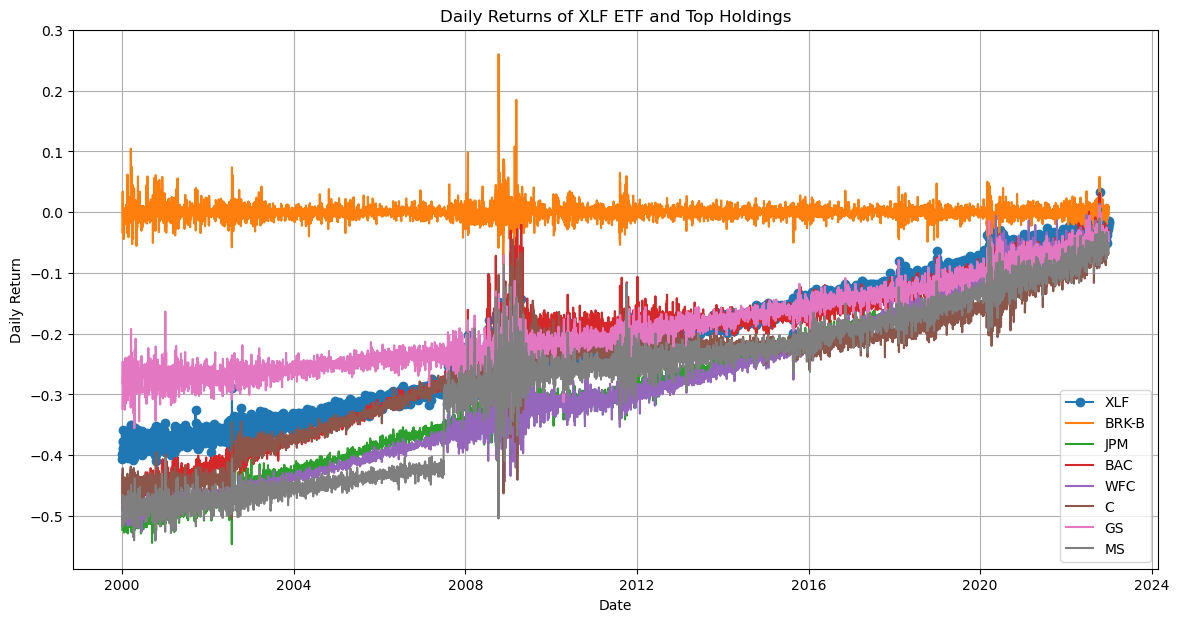

In [4]:
plt.figure(figsize=(14, 7)) 
plt.plot(combined_data.index, combined_data['Return_XLF'], label='XLF', linestyle='-', marker='o')
for ticker in top_holdings_tickers:
    plt.plot(combined_data.index, combined_data[f'Return_{ticker}'], label=ticker)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.title('Daily Returns of XLF ETF and Top Holdings')
plt.legend()
plt.grid(True)
plt.show()

As you see all the returns follows an increasing trend except for BRK-B. Now we can find the correlation matrix between the daily return column:

In [5]:
return_columns = ['Return_XLF'] + [f'Return_{ticker}' for ticker in top_holdings_tickers]
returns_df = combined_data[return_columns]
correlation_matrix = returns_df.corr()
print(correlation_matrix)


              Return_XLF  Return_BRK-B  Return_JPM  Return_BAC  Return_WFC  \
Return_XLF      1.000000      0.045955    0.994266    0.970015    0.993828   
Return_BRK-B    0.045955      1.000000    0.034461    0.054110    0.032118   
Return_JPM      0.994266      0.034461    1.000000    0.965601    0.993899   
Return_BAC      0.970015      0.054110    0.965601    1.000000    0.953858   
Return_WFC      0.993828      0.032118    0.993899    0.953858    1.000000   
Return_C        0.951407      0.062667    0.953558    0.984710    0.938275   
Return_GS       0.970544      0.073331    0.971823    0.910761    0.976375   
Return_MS       0.977248      0.045852    0.966733    0.977714    0.963641   

              Return_C  Return_GS  Return_MS  
Return_XLF    0.951407   0.970544   0.977248  
Return_BRK-B  0.062667   0.073331   0.045852  
Return_JPM    0.953558   0.971823   0.966733  
Return_BAC    0.984710   0.910761   0.977714  
Return_WFC    0.938275   0.976375   0.963641  
Return_C      1

The data seems to be highly correlated from this point of viwe, Now we define the rolling correlation which is a statistical measure that calculate the relationship between two specific variable, in an specific amount of time. for example here we use the quarter 90 days minus the number of weekends so the winod we are using here is 365-number of weekends. Then we drop the NAs from the data and we have the following result: 

In [6]:
window = 261
rolling_correlations = pd.DataFrame(index=combined_data.index)

for ticker in top_holdings_tickers:
    rolling_correlations[f'Corr_{ticker}'] = combined_data['Return_XLF'].rolling(window).corr(combined_data[f'Return_{ticker}'])

rolling_correlations = rolling_correlations.dropna()
rolling_correlations

,Corr_BRK-B,Corr_JPM,Corr_BAC,Corr_WFC,Corr_C,Corr_GS,Corr_MS
Date,,,,,,,
2001-01-12,0.326400,0.695842,0.700925,0.661519,0.729314,0.532989,0.586830
2001-01-16,0.319033,0.693249,0.696260,0.658786,0.725431,0.524924,0.585807
2001-01-17,0.317090,0.694128,0.692735,0.658896,0.722406,0.520185,0.581245
2001-01-18,0.319514,0.693349,0.692992,0.658128,0.724209,0.519029,0.579953
2001-01-19,0.312495,0.694993,0.689172,0.654996,0.719843,0.514212,0.577165
...,...,...,...,...,...,...,...
2022-12-23,0.762425,0.888635,0.901550,0.873058,0.808202,0.877048,0.833803
2022-12-27,0.766733,0.888065,0.901120,0.872537,0.807651,0.875199,0.831815
2022-12-28,0.771045,0.887953,0.901336,0.872590,0.807764,0.875639,0.832492


Then we want to choose the one that has correlation less than 10% and we restore them as outsiders.

In [19]:
def identify_outsiders(correlations, threshold=0.20):
    quantile_threshold = correlations.quantile(threshold, axis=1)
    outsiders = correlations.apply(lambda x: x < quantile_threshold, axis=0)
    return outsiders

outsiders = identify_outsiders(rolling_correlations)
outsiders

,Corr_BRK-B,Corr_JPM,Corr_BAC,Corr_WFC,Corr_C,Corr_GS,Corr_MS
Date,,,,,,,
2001-01-12,True,False,False,False,False,True,False
2001-01-16,True,False,False,False,False,True,False
2001-01-17,True,False,False,False,False,True,False
2001-01-18,True,False,False,False,False,True,False
2001-01-19,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...
2022-12-23,True,False,False,False,True,False,False
2022-12-27,True,False,False,False,True,False,False
2022-12-28,True,False,False,False,True,False,False


Then we determine "outsider" stocks at different points in time.

In [20]:
quarters = combined_data.resample('Q').last().index

quarterly_outsiders = {}

for quarter_end in quarters:
    quarter_correlations = rolling_correlations.loc[:quarter_end].tail(1)
    outsiders = identify_outsiders(quarter_correlations)
    quarterly_outsiders[quarter_end] = outsiders


At last, Compute average return differences between the portfolio of "outsider" stocks and the ETF.

In [21]:
outsiders.shape

(1, 7)

In [11]:
return_differences = []

for quarter_end in combined_data.resample('Q').last().index:
    print(quarter_end)
    outsiders_for_quarter = outsiders.loc[quarter_end]
    outsider_stocks = outsiders_for_quarter.index[outsiders_for_quarter].tolist()

    if outsider_stocks:
        outsider_returns = combined_data.iloc[combined_data.index.get_loc(quarter_end):combined_data.index.get_loc(quarter_end + pd.DateOffset(days=40)), 1:][outsider_stocks].mean(axis=1).mean()
        etf_returns = combined_data.iloc[combined_data.index.get_loc(quarter_end):combined_data.index.get_loc(quarter_end + pd.DateOffset(days=40)), 1:]['Return_XLF'].mean()

        return_difference = outsider_returns - etf_returns
        return_differences.append(return_difference)

average_return_difference = sum(return_differences) / len(return_differences)
print(f'\nAverage return difference: {average_return_difference:.4f}')


2000-03-31 00:00:00


KeyError: Timestamp('2000-03-31 00:00:00')